8189 400 100


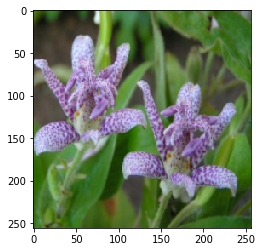

In [24]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


PATH = '/Users/stevenneira/Desktop/Work/studing/FlowersIA/'
INPATH = PATH + 'inImages'
OUTPATH = PATH + 'outImages'
CHECKP = PATH + 'checkpoints'
imgurls = os.listdir(INPATH)
n=500
train_n=round(n*0.80)
#Listado randomizado 
randurls=np.copy(imgurls)
np.random.shuffle(randurls)
#Particiom train/tet
tr_urls=randurls[:train_n]
ts_urls= randurls[train_n:n]
print(len(imgurls),len(tr_urls),len(ts_urls))
#rescalar imagenes
IMG_WIDTH=256
IMG_HEIGHT=256

def resize(inimg,tgimg,height,width):
    
  inimg=tf.image.resize(inimg,[height,width])
  tgimg=tf.image.resize(tgimg,[height,width])
  return inimg,tgimg
#normaliza el rango[-1, +1]

def normalize(inimg,tgimg):
  inimg=(inimg/127.5)-1
  tgimg=(tgimg/127.5)-1
  return inimg,tgimg


#aumentacion de datos :random crop+flip
def random_jitter(inimg,tgimg):
  
  inimg,tgimg = resize(inimg,tgimg,286,286)
  
  stacked_image=tf.stack([inimg,tgimg], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2,IMG_HEIGHT,IMG_WIDTH,3])
  
  inimg,tgimg=cropped_image[0],cropped_image[1]
  
  if np.random.uniform(0,1) > 0.5 :
    inimg=tf.image.flip_left_right(inimg)
    tgimg=tf.image.flip_left_right(tgimg)
    
  return inimg,tgimg

def load_image(filename,augment=True):
  inimg=tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH+'/'+filename)),tf.float32)[..., :3]
  
  tgimg=tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH+'/'+filename)),tf.float32)[..., :3]
  
  inimg,tgimg=resize(inimg,tgimg,IMG_HEIGHT,IMG_WIDTH)
  if augment:
    inimg,tgimg = random_jitter(inimg,tgimg)
  inimg,tgimg= normalize(inimg,tgimg)
  return inimg, tgimg      
def load_train_image(filename):
  return load_image(filename,True)
def load_test_image(filename):
  return load_image(filename,False)

plt.imshow(((load_train_image(randurls[0])[1]) + 1) / 2) 



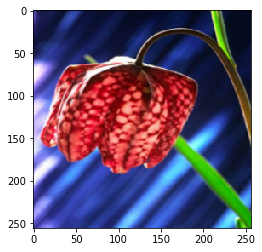

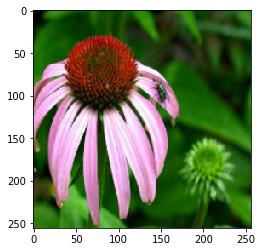

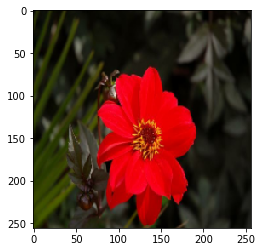

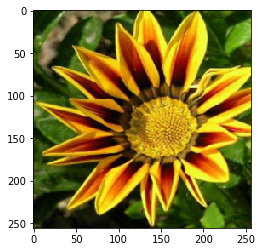

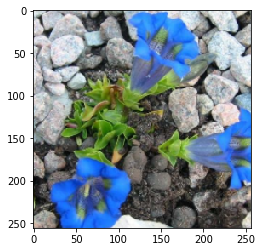

In [15]:

train_dataset=tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset=train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset=train_dataset.batch(1)

for inimg,tgimg in  train_dataset.take(5):
    plt.imshow(((tgimg[0,...]) + 1) / 2)
    plt.show()
    

test_dataset=tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset=test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset=test_dataset.batch(1)


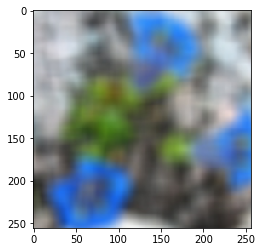

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


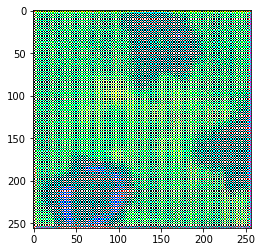

In [16]:
from tensorflow.keras.layers import *
from tensorflow.keras import *
def downsample(filters,apply_batchnorm=True):
  initializer=tf.random_normal_initializer(0,0.02)
  result=Sequential()
  #capa convolucional
  result.add(Conv2D(filters, 
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))
  if apply_batchnorm:
  #capa de batch normalization
      result.add(BatchNormalization())
  #capa de activacion
  result.add(LeakyReLU())
  return result
downsample(64)  
def upsample(filters,apply_dropout=False):
  initializer=tf.random_normal_initializer(0,0.02)
  result=Sequential()
  #capa convolucional
  result.add(Conv2DTranspose(filters, 
                              kernel_size=4,
                              strides=2,
                              padding="same",
                              kernel_initializer=initializer,
                              use_bias=False))
  result.add(BatchNormalization())
  if apply_dropout:
  #capa de batch normalization
      result.add( Dropout(0.5))
  #capa de activacion
  result.add(ReLU())
  return result
upsample(64)  
def Generator():
  inputs=tf.keras.layers.Input(shape=[None,None,3])

  down_stack=[
              downsample(64, apply_batchnorm=False),
              downsample(128),
              downsample(256),
              downsample(512),
              downsample(512),
              downsample(512),
              downsample(512),
              downsample(512),
  ]
  up_stack=[
            upsample(512,apply_dropout=True),
            upsample(512,apply_dropout=True),
            upsample(512,apply_dropout=True),
            upsample(512),
            upsample(256),
            upsample(128),
            upsample(64),

  ]
  initializer=tf.random_normal_initializer(0,0.02)
  last=Conv2DTranspose(filters=3,
                       kernel_size=4,
                       strides=2,
                       padding="same",
                       kernel_initializer=initializer,
                       activation="tanh")
  x=inputs
  s= []  
  concat=Concatenate()
  
  for down in down_stack:
    x= down(x)
    s.append(x)
  
  s =reversed(s[:-1])  
  
  for up ,sk in zip (up_stack,s):
    x=up(x)
    x=concat([x,sk])

  last=last(x)
  return Model(inputs=inputs,outputs=last )
generator=Generator()
gen_output=generator(((inimg+1)*255), training=False)
plt.imshow(((inimg[0,...]) + 1) /2)
plt.show()
plt.imshow(gen_output[0,...])


TensorShape([1, 16, 16, 1])

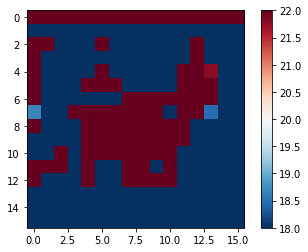

In [17]:
def Discriminator():
  ini=Input(shape=[None,None,3],name="input_img")
  gen=Input(shape=[None,None,3],name="gener_img")
  con=concatenate([ini,gen])
  initializer=tf.random_normal_initializer(0,0.2)
  down1=downsample(64,apply_batchnorm=False)(con)
  down2=downsample(128)(down1)
  down3=downsample(256)(down2)
  down4=downsample(512)(down3)

  last=tf.keras.layers.Conv2D(filters=1,
                              kernel_size=4,
                              strides=1,
                              kernel_initializer=initializer,
                              padding="same")(down4)
  return tf.keras.Model(inputs=[ini,gen],outputs=last)    

discriminator=Discriminator()       
disc_out=discriminator([((inimg+1)*255),gen_output], training=False)
plt.imshow(disc_out[0,...,-1],vmin=20,vmax=20,cmap='RdBu_r')
plt.colorbar()
disc_out.shape       




In [23]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

loss_object=tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(disc_real_output, disc_generated_output):
  #Diferencia entre los true por ser real y el detectado por el discriminador
  real_loss=loss_object(tf.ones_like(disc_real_output),disc_real_output)
  #Diferencia entre los false por ser generado y el detectado por el discriminador
  generated_loss=loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)

  total_disc_loss=real_loss + generated_loss

  return total_disc_loss

LAMBDA=100
def generator_loss(disc_generated_output,gen_output,target):
  gan_loss=loss_object(tf.ones_like(disc_generated_output),disc_generated_output)

  #mean absolute error
  l1_loss=tf.reduce_mean(tf.abs(target - gen_output))
  total_gen_loss= gan_loss + (LAMBDA* l1_loss)
  return total_gen_loss

def generate_images(model,test_input, tar, save_filename=False,display_imgs=True):
  prediction=model(test_input,training=True)
  if save_filename:
    tf.keras.preprocessing.image.save_img(CHECKP + '/'+save_filename +'.jpg', prediction[0,...])
  plt.figure(figsize=(10,10))

  display_list=[test_input[0],tar[0],prediction[0]]
  title=['Input image','Ground Truth','Predicted Image']
  if display_imgs:
    for i in range(3):
      plt.subplot(1,3,i+1)
      plt.title(title[i])
      plt.imshow(display_list[i]*0.5+0.5)
      plt.axis('off')
  plt.show()

@tf.function() 
def train_step(input_image,target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    output_image =generator(input_image,training=True)
    output_gen_discr=discriminator([output_image,input_image],training=True)
    output_trg_discr=discriminator([output_image,input_image],training=True)
    discr_loss=discriminator_loss(output_trg_discr,output_gen_discr)
    gen_loss=generator_loss(output_gen_discr,output_image,target)

    generator_grads=gen_tape.gradient(gen_loss,generator.trainable_variables)
    discriminator_grads=discr_tape.gradient(discr_loss,discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_grads,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grads,discriminator.trainable_variables))





from  IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range (epochs):
    imgi=0
    for input_image, target in dataset:
      print('epoch'+str(epoch)+'-train:' +str(imgi)+'/'+str(len(tr_urls)))
      imgi+=1
      train_step(input_image,target)
      clear_output(wait=True)
    imgi=0
    for inp,tar in test_dataset.take(5):
      generate_images(generator,inp,tar,str(imgi)+'_'+str(epoch),display_imgs=True)
      imgi+=1



In [ ]:
train(train_dataset,100)

epoch13-train:12/400
